<h1>Sistem rekomendasi film dengan Colabborative Filtering</h1>
Project ini dibuat untuk memberi rekomendasi film kepada user


> Sumber dataset : https://www.kaggle.com/zeeshanmulla/recommendation-system-movie?select=Recommendation+System.csv

> Author : https://www.kaggle.com/zeeshanmulla











# Import dataset dari google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommendation System.csv')
title = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Movie_Id_Titles')
dfn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommendation System.csv')
titlen = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Movie_Id_Titles')

Keterangan label

*   item_id = ID judul film
*   user_id = ID user
*   title = judul film
*   rating = penilaian user





In [ ]:
title.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
df.head()

,0,50,5,881250949
0,0,172,5,881250949
1,0,133,1,881250949
2,196,242,3,881250949
3,186,302,3,891717742
4,22,377,1,878887116


Memberi label pada dataframe

In [ ]:
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
df.head()

,user_id,item_id,rating,timestamp
0,0,172,5,881250949
1,0,133,1,881250949
2,196,242,3,881250949
3,186,302,3,891717742
4,22,377,1,878887116


# Mengecek apakah ada miss value

In [ ]:
miss_value = df.isnull().sum()
print(miss_value)

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64


In [ ]:
df.describe()

,user_id,item_id,rating,timestamp
count,100002.000000,100002.000000,100002.000000,1.000020e+05
mean,462.475500,425.524670,3.529849,8.835288e+08
std,266.619776,330.797313,1.125700,5.343812e+06
min,0.000000,1.000000,1.000000,8.747247e+08
25%,254.000000,175.000000,3.000000,8.794487e+08
50%,447.000000,322.000000,4.000000,8.828269e+08
75%,682.000000,631.000000,4.000000,8.882600e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


Mengecek user id dengan id 0

In [ ]:
checkUser = (df.user_id == 0).sum()
print(checkUser)

2


Mengganti User id 0 dengan 945 agar jumlah user menjadi 944

In [ ]:
df['user_id'] = df['user_id'].replace([0,],[945])

In [ ]:
print('jumlah user :', len(df.user_id.unique()))

jumlah user : 944


# Data preparation

Menghapus label yang tidak digunakan

In [ ]:
df = df.drop(labels='timestamp', axis=1)
df.head()

,user_id,item_id,rating
0,945,172,5
1,945,133,1
2,196,242,3
3,186,302,3
4,22,377,1


Membuat variable yang berisi dataframe dengan judul

In [ ]:
title_name = pd.merge(df,title,on='item_id')
title_name

,user_id,item_id,rating,title
0,945,172,5,"Empire Strikes Back, The (1980)"
1,213,172,5,"Empire Strikes Back, The (1980)"
2,92,172,4,"Empire Strikes Back, The (1980)"
3,77,172,3,"Empire Strikes Back, The (1980)"
4,194,172,3,"Empire Strikes Back, The (1980)"
...,...,...,...,...
99997,840,1674,4,Mamma Roma (1962)
99998,655,1640,3,"Eighth Day, The (1996)"
99999,655,1637,3,Girls Town (1996)
100000,655,1630,3,"Silence of the Palace, The (Saimt el Qusur) (1..."


Cek missing value

In [ ]:
title_name.isnull().sum()

user_id    0
item_id    0
rating     0
title      0
dtype: int64

Membuat variable fix_title dan sort berdasarkan item_id

In [ ]:
fix_title = title_name.sort_values('item_id', ascending=True)
fix_title

,user_id,item_id,rating,title
3937,308,1,4,Toy Story (1995)
4247,893,1,5,Toy Story (1995)
4246,336,1,3,Toy Story (1995)
4245,303,1,5,Toy Story (1995)
4244,886,1,4,Toy Story (1995)
...,...,...,...,...
99960,863,1678,1,Mat' i syn (1997)
99940,863,1679,3,B. Monkey (1998)
99967,863,1680,2,Sliding Doors (1998)
99986,896,1681,3,You So Crazy (1994)


Menghitung jumlah unik item_id

In [ ]:
len(fix_title.item_id.unique())

1682

Menghilangkan duplikat pada variable fix_title

In [ ]:
fix_title = fix_title.drop_duplicates('item_id')
fix_title

,user_id,item_id,rating,title
3937,308,1,4,Toy Story (1995)
24328,442,2,3,GoldenEye (1995)
35731,291,3,3,Four Rooms (1995)
7508,293,4,4,Get Shorty (1995)
12464,741,5,3,Copycat (1995)
...,...,...,...,...
99960,863,1678,1,Mat' i syn (1997)
99940,863,1679,3,B. Monkey (1998)
99967,863,1680,2,Sliding Doors (1998)
99986,896,1681,3,You So Crazy (1994)


Konversi data series menjadi list menggunakan tolist dari library numpy

In [ ]:
title_id = fix_title['item_id'].tolist()
title_name = fix_title['title'].tolist()
rating_title = fix_title['rating'].tolist()
print(len(title_id))
print(len(title_name))
print(len(rating_title))

1682
1682
1682


Membuat dictionary key value untuk title_id, title_name, dan rating_title

In [ ]:
title_new = pd.DataFrame({
    'id': title_id,
    'title_name': title_name,
    'rating_title' : rating_title,
})
title_new

,id,title_name,rating_title
0,1,Toy Story (1995),4
1,2,GoldenEye (1995),3
2,3,Four Rooms (1995),3
3,4,Get Shorty (1995),4
4,5,Copycat (1995),3
...,...,...,...
1677,1678,Mat' i syn (1997),1
1678,1679,B. Monkey (1998),3
1679,1680,Sliding Doors (1998),2
1680,1681,You So Crazy (1994),3


Encode fitur user_id dan Item_id menjadi index integer

In [ ]:
user_ids = df['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
title_ids = df['item_id'].unique().tolist()
title_to_title_encoded = {x: i for i, x in enumerate(title_ids)}
title_encoded_to_title = {i: x for i, x in enumerate(title_ids)}

Mapping user_id dan Item_id ke dataframe

In [ ]:
df['user'] = df['user_id'].map(user_to_user_encoded)
df['titles'] = df['item_id'].map(title_to_title_encoded)

Mengubah data rating menjadi float

In [ ]:
import numpy as np
df['rating'] = df['rating'].values.astype(np.float32)

Data checking

In [ ]:
num_users = len(user_to_user_encoded)
print(num_users)

num_titles = len(title_encoded_to_title)
print(num_titles)

min_rating = min(df['rating'])
max_rating = max(df['rating'])
 
print('Number of User: {}, Number of titles: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_titles, min_rating, max_rating
))

944
1682
Number of User: 944, Number of titles: 1682, Min Rating: 1.0, Max Rating: 5.0


# Train test split

Pengacakan data

In [ ]:
df =df.sample(frac=1, random_state=42)
df

,user_id,item_id,rating,user,titles
62004,327,184,3.0,312,373
58589,665,109,4.0,661,199
1956,224,20,1.0,15,61
11529,87,25,4.0,55,88
39495,378,1531,4.0,370,1347
...,...,...,...,...,...
6265,316,735,4.0,284,1016
54886,434,743,1.0,434,768
76820,561,235,3.0,557,182
860,235,70,5.0,196,423


Membuat variable x untuk mencocokan data user dan titles, dan variable y untuk membuat rating dari hasil

In [ ]:
x = df[['user', 'titles']].values
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

Membagi data train sebesar 80% dan data validasi sebesar 20% total data

In [ ]:
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[312 373]
 [661 199]
 [ 15  61]
 ...
 [557 182]
 [196 423]
 [ 59 981]] [0.5  0.75 0.   ... 0.5  1.   0.75]


# Training model

Membuat class RecommenderNet dengan keras model class

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
class RecommenderNet(tf.keras.Model):
 
  def __init__(self, num_users, num_titles, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_titles = num_titles
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.titles_embedding = layers.Embedding(
        num_titles,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.titles_bias = layers.Embedding(num_titles, 1)
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    titles_vector = self.titles_embedding(inputs[:, 1])
    titles_bias = self.titles_bias(inputs[:, 1])
 
    dot_user_titles = tf.tensordot(user_vector, titles_vector, 2) 
 
    x = dot_user_titles + user_bias + titles_bias
    
    return tf.nn.sigmoid(x)

Inisialisasi model

In [ ]:
model = RecommenderNet(num_users, num_titles, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Memulai training

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 50,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
1601/1601 [==============================] - 6s 3ms/step - loss: 0.6896 - root_mean_squared_error: 0.3076 - val_loss: 0.6853 - val_root_mean_squared_error: 0.3063
Epoch 2/100
1601/1601 [==============================] - 4s 3ms/step - loss: 0.6705 - root_mean_squared_error: 0.2918 - val_loss: 0.6698 - val_root_mean_squared_error: 0.2935
Epoch 3/100
1601/1601 [==============================] - 4s 3ms/step - loss: 0.6538 - root_mean_squared_error: 0.2775 - val_loss: 0.6537 - val_root_mean_squared_error: 0.2798
Epoch 4/100
1601/1601 [==============================] - 4s 3ms/step - loss: 0.6475 - root_mean_squared_error: 0.2722 - val_loss: 0.6494 - val_root_mean_squared_error: 0.2760
Epoch 5/100
1601/1601 [==============================] - 4s 3ms/step - loss: 0.6442 - root_mean_squared_error: 0.2694 - val_loss: 0.6464 - val_root_mean_squared_error: 0.2735
Epoch 6/100
1601/1601 [==============================] - 4s 3ms/step - loss: 0.6414 - root_mean_squared_error: 0.2669 - val_l

Visualisasi hasil training

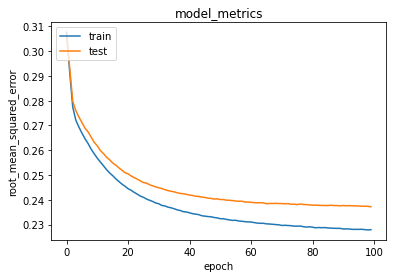

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Mendapatkan Rekomendasi judul film

Membuat variable yang berisi judul film yang sudah dan belum di tonton user

In [ ]:
title_df = title_new
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommendation System.csv')
df2.columns = ['user_id', 'item_id', 'rating', 'timestamp']
 
users_id = df2.user_id.sample(1).iloc[0]
title_watched_by_user = df2[df2.user_id == users_id]

title_not_watched = title_df[~title_df['id'].isin(title_watched_by_user.user_id.values)]['id'] 
title_not_watched = list(
    set(title_not_watched)
    .intersection(set(title_to_title_encoded.keys()))
)
 
title_not_watched = [[title_to_title_encoded.get(x)] for x in title_not_watched]
user_encoder = title_to_title_encoded.get(users_id)
user_title_array = np.hstack(
    ([[user_encoder]] * len(title_not_watched), title_not_watched)
)

Memperoleh rekomendasi film dengan fungsi predict

In [ ]:
ratings = model.predict(user_title_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_title_ids = [
    title_encoded_to_title.get(title_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(users_id))
print('===' * 9)
print('Title with high ratings from user')
print('----' * 8)
 
top_title_user = (
    title_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .user_id.values
)
 
title_df_rows = title_df[title_df['id'].isin(top_title_user)]
for row in title_df_rows.itertuples():
    print(row.title_name, ':', row.rating_title)
 
print('----' * 8)
print('Top 10 title recommendation')
print('----' * 8)
print('Title          |          Rating')
print('----' * 8)
 
recommended_title = title_df[title_df['id'].isin(recommended_title_ids)]
for row in recommended_title.itertuples():
    print(row.title_name,':', row.rating_title)

Showing recommendations for users: 13
Title with high ratings from user
--------------------------------
Mighty Aphrodite (1995) : 4
--------------------------------
Top 10 title recommendation
--------------------------------
Title          |          Rating
--------------------------------
Usual Suspects, The (1995) : 5
Star Wars (1977) : 4
Shawshank Redemption, The (1994) : 5
Silence of the Lambs, The (1991) : 4
Wrong Trousers, The (1993) : 5
12 Angry Men (1957) : 4
Schindler's List (1993) : 5
Close Shave, A (1995) : 4
Casablanca (1942) : 5
Rear Window (1954) : 5
